In [5]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn import preprocessing


RANDOM_SEED = 42

In [6]:
dataset_test = 'glove_data_test/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [7]:
def augment_data_with_noise(data, noise_scale):
    # Calculate statistics for each column except the first one (assuming it contains labels)
    column_stats = data[:, 1:].mean(axis=0), data[:, 1:].std(axis=0)

    # Generate noise for each column except the first one
    noise = np.random.normal(loc=0, scale=column_stats[1] * noise_scale, size=data[:, 1:].shape)

    # Add noise to each column except the first one
    augmented_data = data.copy()
    augmented_data[:, 1:] += noise

    return augmented_data

directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

# Augment data with noise
augmented_data = augment_data_with_noise(X_dataset, 0.1)
augmented_data2 = augment_data_with_noise(X_dataset, 0.01)
augmented_data3 = augment_data_with_noise(X_dataset, 0.005)
augmented_data4 = augment_data_with_noise(X_dataset, 0.05)

X_dataset = np.concatenate([X_dataset, augmented_data, augmented_data2, augmented_data3, augmented_data4], axis=0)

# scale the data


min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_dataset)
X_dataset = pd.DataFrame(x_scaled)
print(X_dataset.shape)
print(X_dataset[:10])

y_dataset = np.concatenate([y_dataset, y_dataset, y_dataset, y_dataset, y_dataset], axis=0)
print(y_dataset.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

(84000, 172)
        0         1         2         3         4         5         6    \
0  0.159199  0.420621  0.554064  0.806170  0.676336  0.561491  0.748224   
1  0.159199  0.419022  0.552399  0.804091  0.674876  0.560962  0.748142   
2  0.159199  0.416156  0.549750  0.800795  0.672621  0.552864  0.746917   
3  0.159199  0.416156  0.549750  0.800795  0.672621  0.552864  0.746917   
4  0.159199  0.416156  0.549750  0.800795  0.672621  0.552864  0.746917   
5  0.159199  0.415498  0.549630  0.800652  0.672618  0.540156  0.745082   
6  0.159199  0.416451  0.551799  0.803285  0.674626  0.511975  0.741371   
7  0.159199  0.416451  0.551799  0.803285  0.674626  0.511975  0.741371   
8  0.159199  0.416451  0.551799  0.803285  0.674626  0.511975  0.741371   
9  0.159199  0.420742  0.557191  0.809862  0.679322  0.487446  0.738505   

        7         8         9    ...       162      163       164       165  \
0  0.280073  0.216727  0.474554  ...  0.492251  0.11659  0.441177  0.492434   
1  

In [8]:
# Initialize empty lists for specialised GQ training
X_train_GQ= []
Y_train_GQ=[]


for i, int_value in enumerate(y_train):
    if int_value == 8 or int_value ==17:
        X_train_GQ.append(X_train[i])
        Y_train_GQ.append(y_train[i])

# Initialize empty lists for specialised GQ testing
X_test_GQ= []
Y_test_GQ=[]


for i, int_value in enumerate(y_test):
    if int_value == 8 or int_value ==17:
        X_test_GQ.append(X_test[i])
        Y_test_GQ.append(y_test[i])


KeyError: 189

In [ ]:
GQ_CLASSES = 2
GQmodel = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(GQ_CLASSES, activation='softmax')
])

GQmodel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = GQmodel.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

val_loss, val_acc = GQmodel.evaluate(X_test, y_test, batch_size = 4)

In [38]:
NUM_CLASSES = 24

In [39]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [40]:
print("X dataset shape: " + X_dataset.shape.__str__())
print("y dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X test dataset shape: " + X_test.shape.__str__())
print("y test dataset shape: " + y_test.shape.__str__())
print("----------------------------------")
print("X dataset train shape: " + X_train.shape.__str__())
print("y dataset train shape: " + y_train.shape.__str__())

X dataset shape: (16800, 172)
y dataset shape: (16800,)
----------------------------------
X test dataset shape: (2400, 172)
y test dataset shape: (2400,)
----------------------------------
X dataset train shape: (11760, 172)
y dataset train shape: (11760,)


In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = 0.862080454826355
Feature 1: Score = 1390.8060302734375
Feature 2: Score = 1395.023681640625
Feature 3: Score = 1403.130126953125
Feature 4: Score = 1136.22900390625
Feature 5: Score = 238.31912231445312
Feature 6: Score = 890.48486328125
Feature 7: Score = 442.7830505371094
Feature 8: Score = 492.4243469238281
Feature 9: Score = 275.5246276855469
Feature 10: Score = 1777.581298828125
Feature 11: Score = 3639.521484375
Feature 12: Score = 3639.123291015625
Feature 13: Score = 228.73355102539062
Feature 14: Score = 1180.600341796875
Feature 15: Score = 4053.324951171875
Feature 16: Score = 4052.638671875
Feature 17: Score = 114.59918212890625
Feature 18: Score = 1253.6556396484375
Feature 19: Score = 1208.8997802734375
Feature 20: Score = 1207.58154296875
Feature 21: Score = 177.20858764648438
Feature 22: Score = 1043.714599609375
Feature 23: Score = 1081.8526611328125
Feature 24: Score = 1080.4342041015625
Feature 25: Score = 3.565718412399292
Feature 26: Score = 13.

In [42]:
# Sort feature scores and get indices of top 50 features
top_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)[:100]

# Extract top 50 features from X_train_selected and X_validation_selected
X_train_top50 = X_train_selected[:, top_indices]
X_validation_top50 = X_validation_selected[:, top_indices]
X_test_top50 = X_test[:, top_indices]

print(X_train_top50.shape)
print(X_validation_top50.shape)
print(X_test_top50.shape)

(11760, 100)
(5040, 100)
(2400, 100)


In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [46]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((86, 2, 1), input_shape=(172, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 10), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 86, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 2, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 2, 64)      │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 2, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,944 (2.97 MB)

 Trainable params: 777,944 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [49]:
# Model checkpoint callback
cp_callback_test = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback_test = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [50]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
# Model compilation
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
# Model compilation
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:

history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0559 - loss: 14.1446
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0565 - loss: 13.6646 - val_accuracy: 0.1720 - val_loss: 3.4517
Epoch 2/1000
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0895 - loss: 4.1793
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0908 - loss: 4.1532 - val_accuracy: 0.2817 - val_loss: 2.9000
Epoch 3/1000
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1576 - loss: 3.4301
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1583 - loss: 3.4069 - val_accuracy: 0.4395 - val_loss: 2.3642
Epoch 4/1000
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2140 - loss: 2.6762
Epoch 4: saving model to model/keypoint_classifier/keypoint

In [54]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
175/184 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0598 - loss: 9.2231
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0606 - loss: 9.0205 - val_accuracy: 0.2823 - val_loss: 3.2126
Epoch 2/1000
178/184 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1320 - loss: 3.9298
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1328 - loss: 3.9177 - val_accuracy: 0.3774 - val_loss: 2.5935
Epoch 3/1000
180/184 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2091 - loss: 2.9355
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2095 - loss: 2.9347 - val_accuracy: 0.5159 - val_loss: 2.1251
Epoch 4/1000
181/184 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2548 - loss: 2.6425
Epoch 4: saving model to model/keypoint_classifi

In [55]:
history3 = model3.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0754 - loss: 4.6155
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0760 - loss: 4.6049 - val_accuracy: 0.4881 - val_loss: 1.7751
Epoch 2/1000
181/184 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3336 - loss: 2.1258
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3348 - loss: 2.1207 - val_accuracy: 0.6730 - val_loss: 0.9928
Epoch 3/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5121 - loss: 1.3628
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5123 - loss: 1.3624 - val_accuracy: 0.7792 - val_loss: 0.6912
Epoch 4/1000
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6154 - loss: 1.0409
Epoch 4: saving model to model/keypoint_c

In [56]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size = 4)

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8302 - loss: 0.7153


In [57]:
val_loss2, vall_acc2 = model2.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8525 - loss: 0.7873


In [58]:
val_loss3, vall_acc3 = model3.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8072 - loss: 0.8767


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


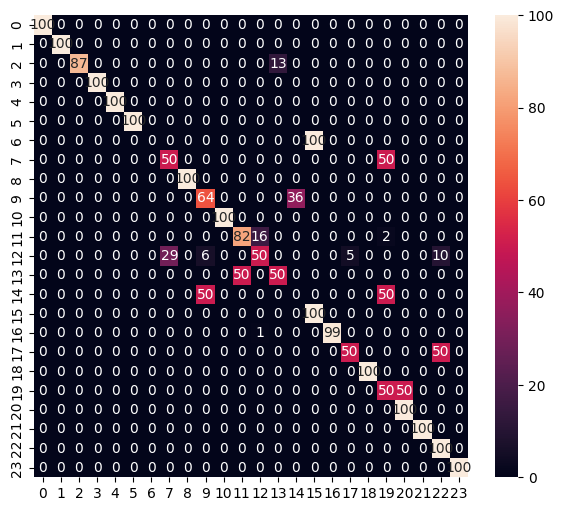

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      0.87      0.93       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       0.63      0.50      0.56       100
           8       1.00      1.00      1.00       100
           9       0.53      0.64      0.58       100
          10       1.00      1.00      1.00       100
          11       0.62      0.82      0.71       100
          12       0.75      0.50      0.60       100
          13       0.79      0.50      0.61       100
          14       0.00      0.00      0.00       100
          15       0.50      1.00      0.67       100
          16       1.00      0.99      0.99       100
     

C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

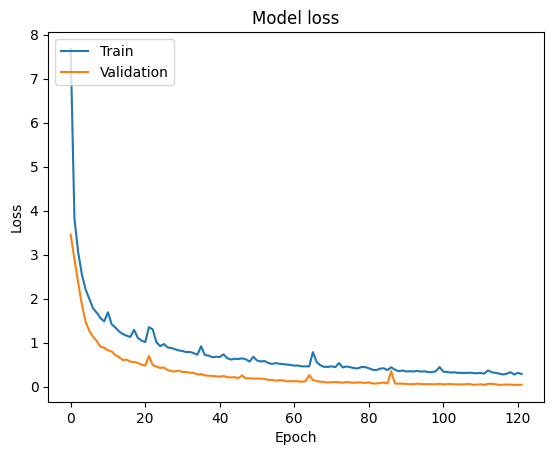

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

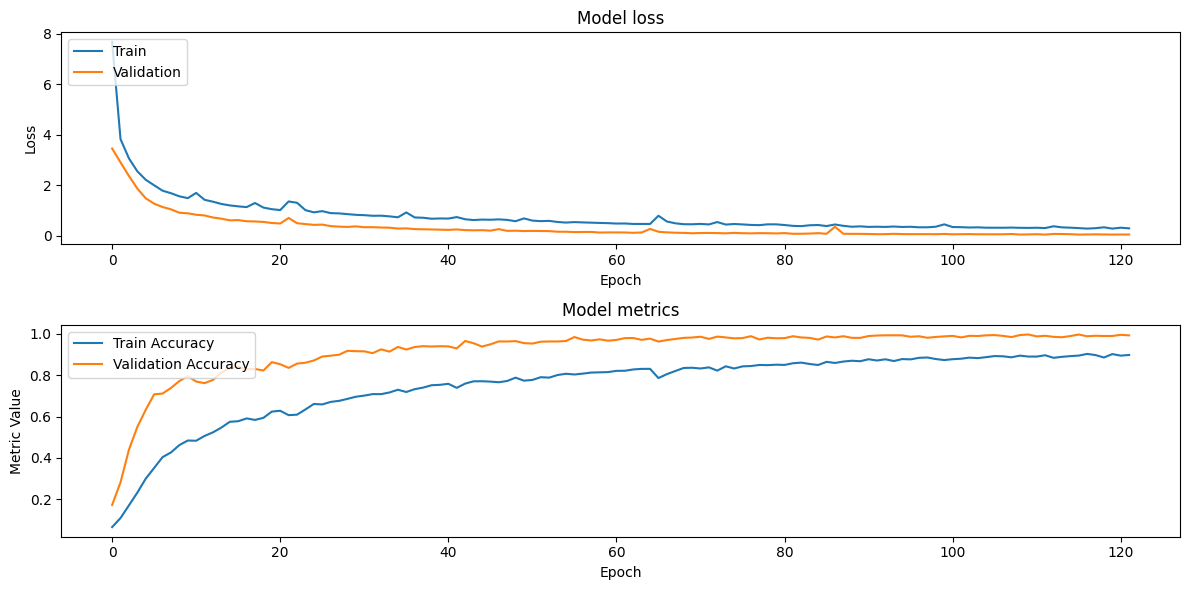

In [61]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

In [62]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define base classifiers
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC(probability=True)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', classifier1),
    ('dt', classifier2),
    ('svc', classifier3)
], voting='hard')  # Change to 'soft' for soft voting

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)


Shape of X_train: (11760, 172)
Shape of y_train: (11760,)


C:\Users\zomaa\IdeaProjects\master\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.5654166666666667
